<center>Провведемо аналіз данних</center>

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

In [242]:
data_dir = '../airbus_test_project/dataset/' #посилання на папку, в якій знаходиться база данних
segmentations = pd.read_csv(os.path.join(data_dir, 'train_ship_segmentations_v2.csv'))
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

In [243]:
segmentations

,ImageId,EncodedPixels
0,00003e153.jpg,<NA>
1,0001124c7.jpg,<NA>
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,<NA>
231719,ffff2aa57.jpg,<NA>
231720,ffff6e525.jpg,<NA>
231721,ffffc50b4.jpg,<NA>


In [244]:
train_images_number = segmentations['ImageId'].nunique()
print(f'Кількість картинок для тренування {train_images_number} ')

Кількість картинок для тренування 192556 


ми бачимо, що повторюється назва картинок, але у різних рядках можуть бути відмічені різні кораблі. Тож Обьєднаємо їх і не забудемо додати пробіл, щоб не збити кодування

In [245]:
segmentations['EncodedPixels'] = segmentations['EncodedPixels']+' '
segmentations = segmentations.groupby('ImageId').agg({"EncodedPixels":"sum"}).reset_index()

In [246]:
segmentations

,ImageId,EncodedPixels
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


заменим 0 снова на Nan

In [247]:
segmentations.loc[segmentations['EncodedPixels'] == '0', 'EncodedPixels'] = np.NaN

In [248]:
segmentations

,ImageId,EncodedPixels
0,00003e153.jpg,<NA>
1,0001124c7.jpg,<NA>
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,<NA>
...,...,...
192551,fffedbb6b.jpg,<NA>
192552,ffff2aa57.jpg,<NA>
192553,ffff6e525.jpg,<NA>
192554,ffffc50b4.jpg,<NA>


In [249]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'Кількість картинок без кораблів {images_without_ships}.')

Кількість картинок без кораблів 150000.


завантажимо цю базу данних у новий файл(гадаю об'єднання однакових рядків покращать результат)

In [250]:
segmentations.to_csv(os.path.join(data_dir, 'train_ship_segmentations_update.csv'), index=False)

описуємо функцію и додаємо у таблицю розміри фотографій. 

In [251]:
def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

було виявлено що всі фотографії 768 * 768, так прописано щоб швидше працювало, для перевірки замінити 
"image = np.zeros((768, 768, 3))" на 
"image = cv2.imread(os.path.join(data_dir, f'train_v2/{name}'))"

In [252]:
segmentations

,ImageId,EncodedPixels,ImageHeight,ImageWidth
0,00003e153.jpg,<NA>,768,768
1,0001124c7.jpg,<NA>,768,768
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768
4,0001b1832.jpg,<NA>,768,768
...,...,...,...,...
192551,fffedbb6b.jpg,NaN,768,768
192552,ffff2aa57.jpg,NaN,768,768
192553,ffff6e525.jpg,NaN,768,768
192554,ffffc50b4.jpg,NaN,768,768


In [253]:
segmentations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192556 entries, 0 to 192555
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        192556 non-null  object
 1   EncodedPixels  42556 non-null   object
 2   ImageHeight    192556 non-null  int64 
 3   ImageWidth     192556 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.9+ MB


In [254]:
segmentations.describe()

,ImageHeight,ImageWidth
count,192556.0,192556.0
mean,768.0,768.0
std,0.0,0.0
min,768.0,768.0
25%,768.0,768.0
50%,768.0,768.0
75%,768.0,768.0
max,768.0,768.0


описуємо функцію і додаєм кількість пікселей на яких є суда

In [255]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()


In [256]:
segmentations['ShipAreaPercentage'] = segmentations.apply(lambda x: pixels_number(x['EncodedPixels']) / 
    (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

In [257]:
print(f'There are {segmentations2.shape[0]} rows.')
segmentations.head(10)

There are 192556 rows.


,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.247531
4,0001b1832.jpg,<NA>,768,768,0.000000
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768,0.199382
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,768,768,0.069173
7,0002d0f32.jpg,<NA>,768,768,0.000000
8,000303d4d.jpg,<NA>,768,768,0.000000
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,768,768,0.072055


In [258]:
segmentations.describe()

,ImageHeight,ImageWidth,ShipAreaPercentage
count,192556.0,192556.0,192556.000000
mean,768.0,768.0,0.112783
std,0.0,0.0,0.404033
min,768.0,768.0,0.000000
25%,768.0,768.0,0.000000
50%,768.0,768.0,0.000000
75%,768.0,768.0,0.000000
max,768.0,768.0,13.007270


Text(0.5, 0, '')

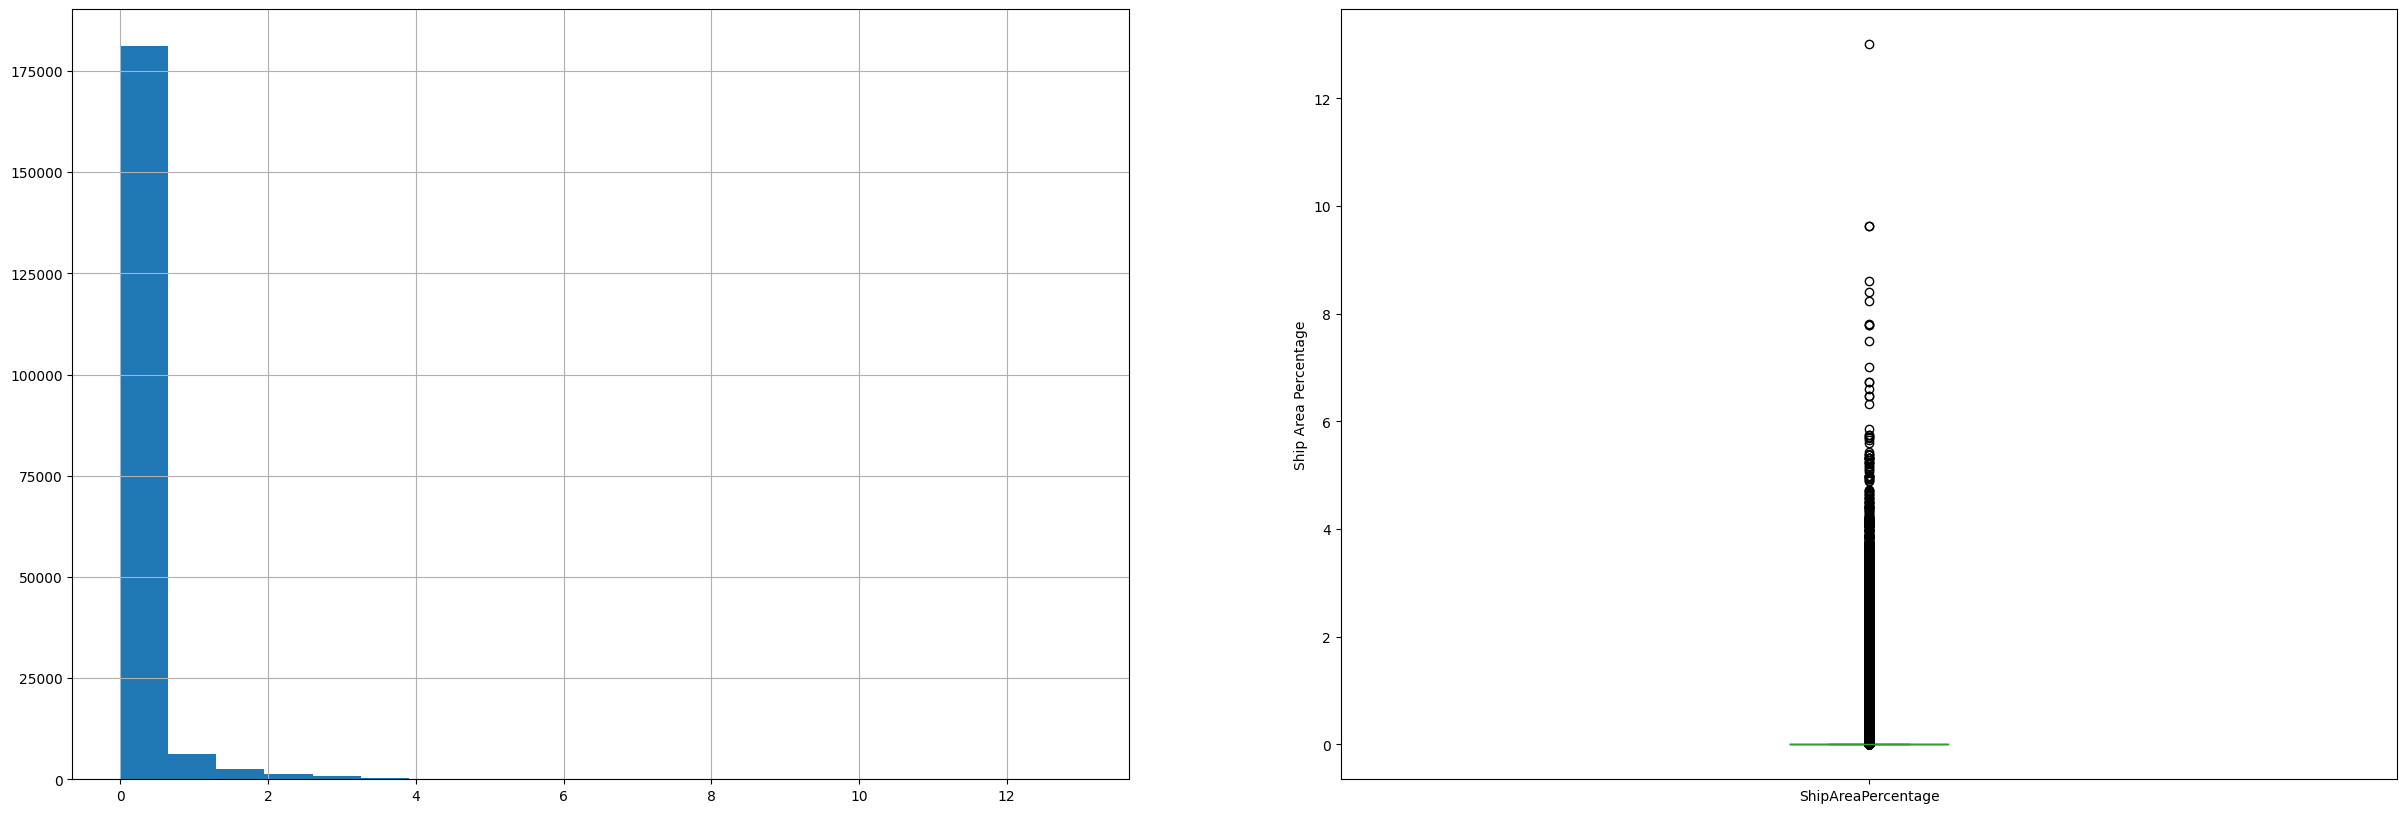

In [259]:
f,ax=plt.subplots(1, 2,figsize=(30,10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')


з висновків можна зробити, що на більшості картинок судов нема, для швидкості навчання моделі можна було б видалити частину пустих картинок з бази, але ми цього робити не будемо, бо прискорили час роботи програми іншим способом